In [17]:
import sys 
import gc
import os 
import re 
import csv
import time
import codecs

import numpy as np
import pandas as pd

import logging
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Bidirectional, Dense, LSTM, Embedding, Dropout, Activation, Lambda
from keras.layers import Add, Flatten, BatchNormalization, concatenate, SpatialDropout1D
from keras.layers import Conv1D, GlobalMaxPool1D, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPooling1D, MaxPool1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam, RMSprop


from gensim.models import Word2Vec
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

start_time = time.time()
np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
class F1Evaluation(Callback):
    def __init__(self, validation_data=(), test_data=(), interval=1):
        super(Callback, self).__init__()
        
        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.X_test, self.y_test = test_data
        self.y_val = self.y_val[:, 1]
        self.y_test = self.y_test[:, 1]
        self.T = 0.5
    
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_val = self.model.predict(self.X_val, verbose=0)[:, 1]
            y_test = self.model.predict(self.X_test, verbose=0)[:, 1]
            y_val[y_val >= self.T] = 1
            y_val[y_val < self.T] = 0
            y_test[y_test >= self.T] = 1
            y_test[y_test < self.T] = 0
            
            val_score = f1_score(self.y_val, y_val)
            test_score = f1_score(self.y_test, y_test)
            print("F1 : Epoch : {} \t Valid Score : {:.4f} \t Test Score : {:.4f}".format(epoch+1, val_score, test_score))

In [4]:
def get_data():
    train = pd.read_csv("../input/avlpp-2/train_ne.csv")
    test = pd.read_csv("../input/avalaraproduct-classification/test_ne_imputed.csv")
    print("Train Shape : {}\nTest Shape :  {}".format(train.shape, test.shape))
    
    train = train[['fold_id', 'title', 'description', 'text', 'category', 'source']]
    test = test[['title', 'description', 'text', 'category']]
    train.dropna(inplace=True)
    
    return train, test

In [5]:
train, test = get_data()
target = 'category'

Train Shape : (1199998, 6)
Test Shape :  (92, 5)


In [6]:
train.head()

,fold_id,title,description,text,category,source
0,1,ziczac black red euro 44,clothing related products b2c shoes shoe laces,ziczac black red euro 44 clothing related prod...,R,valid
1,1,9x9 resista 484938,publishing printing printing services,9x9 resista 484938 publishing printing printin...,S,train
2,1,halle pant short inseam 013049561d0010001 02,clothing related products b2c general,halle pant short inseam 013049561d0010001 02 c...,R,train
3,1,harry houser travel expenses meals,security personnel,harry houser travel expenses meals security pe...,S,train
4,1,tee time 740078609 greens fee composite,admissions green fees privately owned golf course,tee time 740078609 greens fee composite admiss...,R,valid


In [7]:
K = 6

In [8]:
train[target] = train[target].map({"R": 0, "S": 1})
train['target_S'] = np.nan
train['target_R'] = np.nan
train['target_R'] = 1 - train[target].values
train['target_S'] = train[target].values

train.drop([target], axis=1, inplace=True)

In [9]:
test[target] = test[target].map({"R": 0, "S": 1})
test['target_S'] = np.nan
test['target_R'] = np.nan
test['target_R'] = 1 - test[target].values
test['target_S'] = test[target].values

y_test_true = test['target_S'].values
test.drop([target], axis=1, inplace=True)

In [10]:
list_classes = ["target_R", "target_S"]

In [11]:
### Splitter

def splitter(data, k=K):
    
    data_v1 = data[data['fold_id'] == k].copy()
    data_v1.reset_index(drop=True, inplace=True)
    
    train_set = data_v1[data_v1['source'] == 'train'].copy()
    valid_set = data_v1[data_v1['source'] == 'valid'].copy()
    train_set.reset_index(drop=True, inplace=True)
    valid_set.reset_index(drop=True, inplace=True)
    
    del data_v1
    gc.collect()
    
#     print(train_set.shape, valid_set.shape)
    
    return train_set, valid_set, train_set[list_classes].values, valid_set[list_classes].values

In [12]:
T = 0.5
def eval_t(y_pred, y_true=y_test_true):
    y_pred[y_pred >= T] = 1
    y_pred[y_pred < T] = 0
    
    return f1_score(y_true, y_pred)

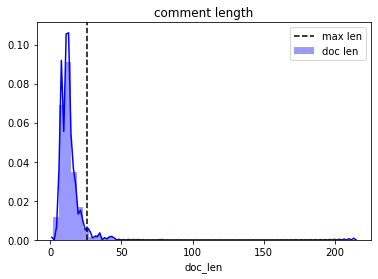

In [13]:
# visualize word length distribution
train['doc_len'] = train['text'].apply(lambda words: len(words.split(" ")))
max_len = np.round(train['doc_len'].mean() + 2*train['doc_len'].std()).astype(int)

sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_len, color='k', linestyle='--', label='max len')
plt.title('comment length')
plt.legend()
plt.show()

In [14]:
max_len

26

In [15]:
embed_size = 100
max_features = 1_000_000
max_len = 50

BS = 128

In [19]:
y_test = test[list_classes].values

X_train, X_valid, y_new_train, y_new_valid = splitter(train)
print(X_train.shape, X_valid.shape, y_new_train.shape, y_new_valid.shape)

(99371, 8) (20593, 8) (99371, 2) (20593, 2)


## Custom Word2Vec

In [20]:
%%time

col = 'text'

values = train[col].progress_apply(lambda x: x.split()).values.tolist() + test[col].progress_apply(
    lambda x: x.split()).values.tolist()
embedding_index = Word2Vec(values, min_count=5, size=embed_size)
print("Length of Vocabulary : {}".format(len(embedding_index.wv.vocab)))

100%|██████████| 92/92 [00:00<00:00, 63393.46it/s]


Length of Vocabulary : 47157
CPU times: user 3min 56s, sys: 1.86 s, total: 3min 58s
Wall time: 2min 29s


In [21]:
embedding_index["shirt"].shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(100,)

In [22]:
raw_text_train = X_train['text'].str.lower()
raw_text_valid = X_valid['text'].str.lower()
raw_text_test = test['text'].str.lower()

In [23]:
%%time

tk = Tokenizer(num_words=max_features, lower=True)
tk.fit_on_texts(raw_text_train.values.tolist() + raw_text_valid.values.tolist() + test['text'].values.tolist())
X_train['seq'] = tk.texts_to_sequences(raw_text_train.values)
X_valid['seq'] = tk.texts_to_sequences(raw_text_valid.values)
test['seq'] = tk.texts_to_sequences(raw_text_test.values)

X_train = pad_sequences(X_train.seq, maxlen=max_len)
X_valid = pad_sequences(X_valid.seq, maxlen=max_len)
test = pad_sequences(test.seq, maxlen=max_len)

CPU times: user 7.04 s, sys: 69.9 ms, total: 7.11 s
Wall time: 7.11 s


## Word2Vec

In [24]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embed_size))
cnt = 0
for word, i in tqdm_notebook(word_index.items()):
    if i>= nb_words:
        continue
    try:
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            cnt += 1
    except KeyError:
        continue
cov = (cnt / nb_words)*100
print("Number of words : {}".format(nb_words))
print("Coverage : {:.2f}".format(cov))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.



Number of words : 157153
Coverage : 21.60


## Modelling Utils

In [25]:
lr = 1e-3
lr_d = 0
units = 128
dr = 0.2

In [26]:
N_EPOCHS = 5
NUM_CLASSES = 2

## FlipCNN

In [27]:
def build_model_flipcnn_forward(test, embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0, filename="flipcnn_forward"):
    
    file_path = "flipcnn_forward-{epoch:02d}.hdf5"
    check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
    f1_val = F1Evaluation(validation_data=(X_valid, y_new_valid), test_data=(test, y_test), interval=1)
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    
    filter_sizes = [1, 2, 3, 4, 5]
    num_filters = 36
    
    inp = Input(shape=(max_len, ))
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(dr)(x)
    
    conv_0 = Conv1D(num_filters, kernel_size=(filter_sizes[0]), kernel_initializer='he_normal', activation='relu')(x)
    conv_1 = Conv1D(num_filters, kernel_size=(filter_sizes[1]), kernel_initializer='he_normal', activation='relu')(x)
    conv_2 = Conv1D(num_filters, kernel_size=(filter_sizes[2]), kernel_initializer='he_normal', activation='relu')(x)
    conv_3 = Conv1D(num_filters, kernel_size=(filter_sizes[3]), kernel_initializer='he_normal', activation='relu')(x)
    
    maxpool_0 = MaxPool1D(pool_size=(max_len - filter_sizes[0] + 1))(conv_0)
    maxpool_1 = MaxPool1D(pool_size=(max_len - filter_sizes[1] + 1))(conv_1)
    maxpool_2 = MaxPool1D(pool_size=(max_len - filter_sizes[2] + 1))(conv_2)
    maxpool_3 = MaxPool1D(pool_size=(max_len - filter_sizes[3] + 1))(conv_3)
    
    z = concatenate([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
    z = Flatten()(z)
    
    outp = Dense(NUM_CLASSES, activation="sigmoid")(z)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=['accuracy'])
    history = model.fit(X_train, y_new_train, batch_size=BS, epochs=N_EPOCHS, validation_data=(X_valid, y_new_valid), verbose=1, 
                        callbacks=[f1_val, check_point, early_stop])
    preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
    
    return model, preds

def build_model_flipcnn_backward(test, embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0, filename="flipcnn_backward"):
    
    file_path = "flipcnn_backward-{epoch:02d}.hdf5"
    check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
    f1_val = F1Evaluation(validation_data=(X_valid, y_new_valid), test_data=(test, y_test), interval=1)
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    
    filter_sizes = [1, 2, 3, 4, 5]
    num_filters = 36
    
    inp = Input(shape=(max_len, )) 
    x = Lambda(lambda x: K.reverse(x, axes=-1))(inp)
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(dr)(x)
    
    conv_0 = Conv1D(num_filters, kernel_size=(filter_sizes[0]), kernel_initializer='he_normal', activation='relu')(x)
    conv_1 = Conv1D(num_filters, kernel_size=(filter_sizes[1]), kernel_initializer='he_normal', activation='relu')(x)
    conv_2 = Conv1D(num_filters, kernel_size=(filter_sizes[2]), kernel_initializer='he_normal', activation='relu')(x)
    conv_3 = Conv1D(num_filters, kernel_size=(filter_sizes[3]), kernel_initializer='he_normal', activation='relu')(x)
    
    maxpool_0 = MaxPool1D(pool_size=(max_len - filter_sizes[0] + 1))(conv_0)
    maxpool_1 = MaxPool1D(pool_size=(max_len - filter_sizes[1] + 1))(conv_1)
    maxpool_2 = MaxPool1D(pool_size=(max_len - filter_sizes[2] + 1))(conv_2)
    maxpool_3 = MaxPool1D(pool_size=(max_len - filter_sizes[3] + 1))(conv_3)
    
    z = concatenate([maxpool_0, maxpool_1, maxpool_2, maxpool_3])
    z = Flatten()(z)
    
    outp = Dense(NUM_CLASSES, activation="sigmoid")(z)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=['accuracy'])
    history = model.fit(X_train, y_new_train, batch_size=BS, epochs=N_EPOCHS, validation_data=(X_valid, y_new_valid), verbose=1, 
                        callbacks=[f1_val, check_point, early_stop])
    preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
    
    return model, preds


def build_model_flipcnn(test, embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0):
    model_1, preds_1 = build_model_flipcnn_forward(test, embedding_matrix, lr=lr, lr_d=lr_d, units=units, dr=dr, filename="flipcnn_forward")
    model_2, preds_2 = build_model_flipcnn_backward(test, embedding_matrix, lr=lr, lr_d=lr_d, units=units, dr=dr, filename="flipcnn_backward")
    
    preds = (preds_1 + preds_2)/2
    
    return model_1, model_2, preds, preds_1, preds_2

In [28]:
model_fow, model_back, avg_preds, for_preds, back_preds = build_model_flipcnn(test, embedding_matrix, lr=lr, lr_d=lr_d, units=units, dr=dr)

Train on 99371 samples, validate on 20593 samples
Epoch 1/5
99371/99371 [==============================] - 10s 99us/step - loss: 0.0324 - accuracy: 0.9913 - val_loss: 0.1548 - val_accuracy: 0.9379
F1 : Epoch : 1 	 Valid Score : 0.9497 	 Test Score : 0.8762

Epoch 00001: saving model to flipcnn_forward-01.hdf5
Epoch 2/5
99371/99371 [==============================] - 5s 51us/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.1803 - val_accuracy: 0.9424
F1 : Epoch : 2 	 Valid Score : 0.9423 	 Test Score : 0.8952

Epoch 00002: saving model to flipcnn_forward-02.hdf5
Epoch 3/5
99371/99371 [==============================] - 5s 50us/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.1595 - val_accuracy: 0.9468
F1 : Epoch : 3 	 Valid Score : 0.9485 	 Test Score : 0.8807

Epoch 00003: saving model to flipcnn_forward-03.hdf5
Epoch 4/5
99371/99371 [==============================] - 5s 48us/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.1683 - val_accuracy: 0.9499
F1 : Epoch : 4 	 Valid 

In [29]:
# # Best epochs indexes : 
# 1. For : 5 0.9057
# 2. Back : 1 0.9444

eval_t(avg_preds), eval_t(for_preds), eval_t(back_preds)

(0.8952380952380952, 0.9056603773584905, 0.8952380952380952)

## BiLSTM

In [30]:
def build_model_bilstm(test, embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0, filename="bilstm"):
    
    file_path = "bilstm-{epoch:02d}.hdf5"
    check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
    f1_val = F1Evaluation(validation_data=(X_valid, y_new_valid), test_data=(test, y_test), interval=1)
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    
    inp = Input(shape=(max_len, ))

    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=['accuracy'])
    history = model.fit(X_train, y_new_train, batch_size=BS, epochs=N_EPOCHS, validation_data=(X_valid, y_new_valid), verbose=1, 
                        callbacks=[f1_val, check_point, early_stop])
    preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
    
    return model, preds

In [31]:
model_bilstm, bilstm_preds = build_model_bilstm(test, embedding_matrix, lr=lr, lr_d=lr_d, units=units, dr=dr, filename="bilstm")

Train on 99371 samples, validate on 20593 samples
Epoch 1/5
99371/99371 [==============================] - 161s 2ms/step - loss: 0.0180 - accuracy: 0.9954 - val_loss: 0.2741 - val_accuracy: 0.8353
F1 : Epoch : 1 	 Valid Score : 0.8959 	 Test Score : 0.8319

Epoch 00001: saving model to bilstm-01.hdf5
Epoch 2/5
99371/99371 [==============================] - 161s 2ms/step - loss: 4.0559e-04 - accuracy: 0.9999 - val_loss: 0.2486 - val_accuracy: 0.9686
F1 : Epoch : 2 	 Valid Score : 0.9726 	 Test Score : 0.8421

Epoch 00002: saving model to bilstm-02.hdf5
Epoch 3/5
99371/99371 [==============================] - 164s 2ms/step - loss: 4.3356e-05 - accuracy: 1.0000 - val_loss: 0.2542 - val_accuracy: 0.9557
F1 : Epoch : 3 	 Valid Score : 0.9700 	 Test Score : 0.8108

Epoch 00003: saving model to bilstm-03.hdf5
Epoch 4/5
99371/99371 [==============================] - 164s 2ms/step - loss: 1.9898e-05 - accuracy: 1.0000 - val_loss: 0.4264 - val_accuracy: 0.8240
F1 : Epoch : 4 	 Valid Score : 0.89

In [32]:
# Best Epoch_ID : 2 : 0.8421
eval_t(bilstm_preds)

0.8035714285714286

## BiLSTM+CNN

In [33]:
def build_model_bilstm_cnn(test, embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0, filename="bilstm_cnn"):
    
    file_path = "bilstm_cnn-{epoch:02d}.hdf5"
    check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
    f1_val = F1Evaluation(validation_data=(X_valid, y_new_valid), test_data=(test, y_test), interval=1)
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    
    inp = Input(shape=(max_len, ))
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(dr)(x)
    
    x = Bidirectional(LSTM(units, return_sequences=True))(x)
    x = Conv1D(64, kernel_size=2, padding="valid", kernel_initializer="he_uniform")(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    
    x = Dense(NUM_CLASSES, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=['accuracy'])
    history = model.fit(X_train, y_new_train, batch_size=BS, epochs=N_EPOCHS, validation_data=(X_valid, y_new_valid), verbose=1, 
                        callbacks=[f1_val, check_point, early_stop])
    preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
    
    return model, preds

In [34]:
model_bilstm_cnn, bilstm_cnn_preds = build_model_bilstm_cnn(test, embedding_matrix, 
                                                                  lr=lr, lr_d=lr_d, units=units, dr=dr, filename="bilstm_cnn")

Train on 99371 samples, validate on 20593 samples
Epoch 1/5
99371/99371 [==============================] - 162s 2ms/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.2228 - val_accuracy: 0.9610
F1 : Epoch : 1 	 Valid Score : 0.9731 	 Test Score : 0.8846

Epoch 00001: saving model to bilstm_cnn-01.hdf5
Epoch 2/5
99371/99371 [==============================] - 162s 2ms/step - loss: 5.4008e-04 - accuracy: 0.9999 - val_loss: 0.2829 - val_accuracy: 0.9616
F1 : Epoch : 2 	 Valid Score : 0.9739 	 Test Score : 0.8972

Epoch 00002: saving model to bilstm_cnn-02.hdf5
Epoch 3/5
99371/99371 [==============================] - 159s 2ms/step - loss: 3.0224e-04 - accuracy: 0.9999 - val_loss: 0.3044 - val_accuracy: 0.9619
F1 : Epoch : 3 	 Valid Score : 0.9742 	 Test Score : 0.8350

Epoch 00003: saving model to bilstm_cnn-03.hdf5
Epoch 4/5
99371/99371 [==============================] - 157s 2ms/step - loss: 5.1368e-04 - accuracy: 0.9998 - val_loss: 0.3842 - val_accuracy: 0.9586
F1 : Epoch : 4 	 Valid 

In [37]:
# Best Epoch_ID : 2 0.8972
eval_t(bilstm_cnn_preds)

0.8118811881188119

## Does Attention help? 

Checking if the Attention layer is worth the hype? 

![Attention Algorithm](https://i.imgur.com/rQQ52by.png)

In [40]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, return_attention=False, **kwargs):
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
#         eij = K.squeeze(K.dot(x, K.expand_dims(self.W)), axis=-1)
    
        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [
                (input_shape[0], input_shape[-1]),
                (input_shape[0], input_shape[1]),
            ]
        return input_shape[0],  input_shape[-1] # self.features_dim

def build_model_bilstm_attention(test, embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0, filename="bilstm_attention"):
    
    file_path = "bilstm_attention-{epoch:02d}.hdf5"
    check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
    f1_val = F1Evaluation(validation_data=(X_valid, y_new_valid), test_data=(test, y_test), interval=1)
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    
    inp = Input(shape=(max_len, ))

    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(LSTM(units, return_sequences=True))(x)
    x, word_scores = Attention(max_len, return_attention=True, name="attention_vec")(x) # Attention(return_attention=True, name="attention_vec")(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=['accuracy'])
    history = model.fit(X_train, y_new_train, batch_size=BS, epochs=1, validation_data=(X_valid, y_new_valid), verbose=1, 
                        callbacks=[f1_val, check_point, early_stop])
    preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
    
    return model, word_scores, preds

In [41]:
model_bilstm_attention, word_scores, bilstm_attention_preds = build_model_bilstm_attention(
    test, embedding_matrix, lr=lr, lr_d=lr_d, units=units, dr=dr, filename="bilstm_attention")

Train on 99371 samples, validate on 20593 samples
Epoch 1/1
99371/99371 [==============================] - 158s 2ms/step - loss: 0.0170 - accuracy: 0.9961 - val_loss: 0.2142 - val_accuracy: 0.9625
F1 : Epoch : 1 	 Valid Score : 0.9746 	 Test Score : 0.8348

Epoch 00001: saving model to bilstm_attention-01.hdf5
92/92 [==============================] - 0s 177us/step


In [42]:
# Best Epoch_ID : 1 
eval_t(bilstm_attention_preds)

0.8347826086956522

## Getting preds from the best model saved.

In [43]:
# Best epochs indexes 

sub = pd.DataFrame()
sub['bilstm_attention'] = bilstm_attention_preds

best_epoch_dict = {
    "bilstm" : [2, model_bilstm],
    "bilstm_cnn" : [2, model_bilstm_cnn],
    "flipcnn_forward" : [5, model_fow],
    "flipcnn_backward" : [1, model_back],
}
avg_preds = np.zeros(for_preds.shape[0])

for key, (epoch_id, model) in best_epoch_dict.items():
    model_path = "{}-0{}.hdf5".format(key, epoch_id)
    print(model_path)
    model.load_weights(model_path)
    preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
    sub[key] = preds
    
    if key in ['flipcnn_forward', 'flipcnn_backward']:
        avg_preds += preds
avg_preds /= 2
sub['flipcnn_average'] = avg_preds

bilstm-02.hdf5
92/92 [==============================] - 0s 171us/step
bilstm_cnn-02.hdf5
92/92 [==============================] - 0s 175us/step
flipcnn_forward-05.hdf5
92/92 [==============================] - 0s 28us/step
flipcnn_backward-01.hdf5
92/92 [==============================] - 0s 25us/step


In [44]:
sub.head()

,bilstm_attention,bilstm,bilstm_cnn,flipcnn_forward,flipcnn_backward,flipcnn_average
0,0.0,0.000009,0.000004,0.000093,0.000299,0.000196
1,1.0,0.771911,0.703757,0.993070,0.983858,0.988464
2,1.0,0.999998,1.000000,0.999768,0.999769,0.999769
3,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.0,0.000044,0.000005,0.000084,0.001529,0.000807


In [45]:
sub.to_csv("temporal_models.csv", index=False)

### Visualising Attention

In [46]:
# Visualization
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import seaborn as sns
sns.set()

In [47]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)

def visualize_attention(model):
    # Make new model for output predictions and attentions
    '''
    model.get_layer('attention_vec').output:
    attention_vec (Attention)    [(None, 128), (None, 54)] <- We want (None,54) that is the word att
    '''
    model_att = Model(inputs=model.input, \
                            outputs=[model.output, model.get_layer('attention_vec').output[-1]])
    idx = np.random.randint(low = 0, high=test.shape[0]) # Get a random test
    tokenized_sample = np.trim_zeros(test[idx]) # Get the tokenized text
    label_probs, attentions = model_att.predict(test[idx:idx+1]) # Perform the prediction

    # Get decoded text and labels
    id2word = dict(map(reversed, tk.word_index.items()))
    decoded_text = [id2word[word] for word in tokenized_sample] 
    
    # Get classification
    label = (label_probs>0.5).astype(int).squeeze() # Only one
    label2id = ['Sincere', 'Insincere']

    # Get word attentions using attenion vector
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0
    
    attentions_text = attentions[0,-len(tokenized_sample):]
    attentions_text = (attentions_text - np.min(attentions_text)) / (np.max(attentions_text) - np.min(attentions_text))
    for token, attention_score in zip(decoded_text, attentions_text):
        #print(token, attention_score)
        token_attention_dic[token] = attention_score
        

    # Build HTML String to viualize attentions
    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    for token, attention in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                            token)
    # Display text enriched with attention scores 
    display(HTML(html_text))
    
    # PLOT EMOTION SCORES
    _labels = ['product', 'service']
    probs = np.zeros(2)
    
    probs[1] = label_probs[0][1]
    probs[0] = 1- label_probs[0][1]
    plt.figure(figsize=(5,2))
    plt.bar(np.arange(len(_labels)), probs.squeeze(), align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
    plt.xticks(np.arange(len(_labels)), _labels)
    plt.ylabel('Scores')
    plt.show()

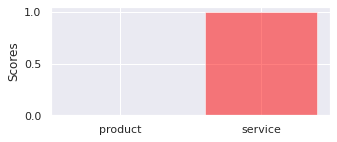

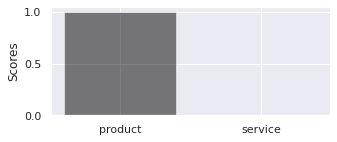

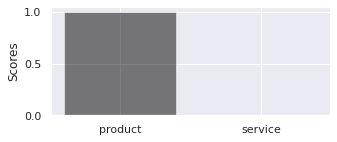

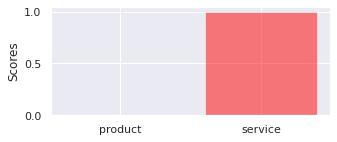

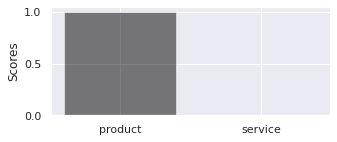

In [48]:
for _ in range(5):
    visualize_attention(model_bilstm_attention)

# Conclusion

We can see that **Temporal Models tends to overfit very fast near 1-2 epochs**.

1. Results : 

    - The best is the **backward CNN** which scored : **0.944**
    - We can infer that **BOW models like CNN work better and faster due to the non-temporal sensical nature of the domain data**.